 # 3.3 MNIST Handwritten Digits

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.layers import *
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras import backend as K

/home/sitibanc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Define Class

In [2]:
class PPAN:
    def __init__(self, img_size=(28, 28), channels=1, noise_dim=20, learning_rates=[2e-4, 2e-4, 1e-3], utility_weight=2, valid_weight=1):
        '''
        Build PPAN model
        Args:
            img_size: tuple, input image size, default=(28, 28)
            channels: int, input image channels, default=1
            noise_dim: int, noise input of mechanism network, default=20
            learning_rates: list, list of learning rates of adversary, discriminator and mechanism, default=[1e-4, 1e-4, 1e-3]
            utility_weight: float, weight of the utility loss, default=2
            valid_weight: float, weight of the discriminator loss, default=1
        Returns:
            PPAN object
        '''
        # Get variables
        self.img_size = img_size
        self.channels = channels
        self.noise_dim = noise_dim
        self.utility_weight = utility_weight
        self.valid_weight = valid_weight
        # Get networks
        self.mechanism = self.build_mechanism()
        self.adversary = self.build_adversary()
        self.discriminator = self.build_discriminator()
        # Setup optimizers
        a_optimizer = SGD(learning_rates[0], clipvalue=0.1)
        d_optimizer = SGD(learning_rates[1], clipvalue=0.1)
        m_optimizer = Adam(learning_rates[2], 0.5)
        # Compile discriminators
        self.adversary.compile(
            loss="categorical_crossentropy", optimizer=a_optimizer, metrics=["accuracy"])
        self.discriminator.compile(
            loss="binary_crossentropy", optimizer=d_optimizer, metrics=["accuracy"])
        # Combined two discriminators with the mechanism(generator)
        noised_img = Input(
            shape=(self.img_size[0]*self.img_size[1]+self.noise_dim,))
        gen_img = self.mechanism(noised_img)
        # Freeze discriminators
        self.adversary.trainable = False
        self.discriminator.trainable = False
        # Get predictions from discriminators
        pred_label = self.adversary(gen_img)
        pred_valid = self.discriminator(gen_img)
        self.ppan = Model(inputs=noised_img, outputs=[
                          pred_label, gen_img, pred_valid])
        # Compile mechanism
        self.ppan.compile(loss=[self.mutual_info_privacy_loss, "binary_crossentropy", "binary_crossentropy"], loss_weights=[
                          self.utility_weight, 1.0, self.valid_weight], optimizer=m_optimizer)
    
    def mutual_info_privacy_loss(self, y_true, y_pred):
        entropy = K.mean(- K.sum(K.log(y_pred + 1e-9) * y_true, axis=1))
        conditional_entropy = K.mean(K.sum(K.log(y_pred + 1e-9) * y_true, axis=1))
        return entropy - conditional_entropy

    def build_mechanism(self):
        model = Sequential(name="Mechanism")

        model.add(Dense(1000, activation="tanh",
                        input_dim=self.img_size[0]*self.img_size[1]*self.channels+self.noise_dim, name="fc1"))
        model.add(Dense(1000, activation="tanh", name="fc2"))
        model.add(Dense(self.img_size[0] *
                        self.img_size[1], activation="sigmoid", name="output"))

        print("\n=== Mechanism Summary ===")
        model.summary()

        return model

    def build_adversary(self):
        model = Sequential(name="Adversary")

        model.add(Dense(1000, activation="tanh",
                        input_dim=self.img_size[0]*self.img_size[1]*self.channels, name="fc1"))
        model.add(Dense(1000, activation="tanh", name="fc2"))
        model.add(Dense(10, activation="softmax", name="output"))

        print("\n=== Adversary Summary ===")
        model.summary()

        return model

    def build_discriminator(self):
        model = Sequential(name="Discriminator")

        model.add(Dense(500, activation="tanh",
                        input_dim=self.img_size[0]*self.img_size[1]*self.channels, name="fc1"))
        model.add(Dense(1, activation="sigmoid", name="output"))

        print("\n=== Discriminator Summary ===")
        model.summary()

        return model

    def train(self, x_train, y_train, x_test, y_test, epochs, batch_size, save_path, print_interval=10, save_interval=50):
        '''
        Train model
        Args:
            x_train: ndarray, training images
            y_train: ndarray, training labels
            x_test: ndarray, testing images
            y_test: ndarray, testing labels
            epochs: int, training epochs
            batch_size: int, training batch size
            save_path: string, saving path for generated images during training process
            print_interval: int, print accuracy & loss every print_interval epochs, default=10
            save_interval: int, save generated images every save_interval, default=50
        Returns:
            None
        '''
        # Flatten images data
        x_train = x_train.reshape(
            (x_train.shape[0], self.img_size[0]*self.img_size[1]*self.channels))
        x_train = x_test.reshape(
            (x_test.shape[0], self.img_size[0]*self.img_size[1]*self.channels))
        # Set labels for discriminator
        valid = np.ones(shape=(batch_size, 1))
        fake = np.zeros(shape=(batch_size, 1))
        # Store training loss and accuracy in an array
        # privacy/realistic/utility loss (a/d/m networks)
        self.losses = np.zeros(shape=(epochs, 3))
        # adversary/discriminator accuracy
        self.accuracies = np.zeros(shape=(epochs, 2))
        # Training
        for e in range(epochs):
            # -------------------------
            # Train Discriminators
            # -------------------------
            # Random sample batch_size images from data
            idx = np.random.randint(
                low=0, high=x_train.shape[0], size=batch_size)
            original_imgs, labels = x_train[idx], y_train[idx]
            # Sample noise and generate a batch of new images
            noise = np.random.uniform(
                low=-1, high=1, size=(batch_size, self.noise_dim))
            gen_imgs = self.mechanism.predict(
                np.hstack((original_imgs, noise)))
            # Train adversary
            self.losses[e, 0], self.accuracies[e,
                                               0] = self.adversary.train_on_batch(gen_imgs, labels)
            # Train discriminator
            d_loss_valid = self.discriminator.train_on_batch(
                original_imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            self.losses[e, 1], self.accuracies[e, 1] = 0.5 * \
                np.add(d_loss_valid, d_loss_fake)
            # -------------------------
            # Train Generator
            # -------------------------
            # Sample batch_size images and noise
            idx = np.random.randint(
                low=0, high=x_train.shape[0], size=batch_size)
            original_imgs, labels = x_train[idx], y_train[idx]
            noise = np.random.uniform(
                low=-1, high=1, size=(batch_size, self.noise_dim))
            # Train mechanism
            m_loss = self.ppan.train_on_batch(
                np.hstack((original_imgs, noise)), [labels, original_imgs, fake])
            self.losses[e, 2] = m_loss[0] + m_loss[1] * self.utility_weight + m_loss[2] * self.valid_weight

            # Print loss at the beginning/end and every print_interval
            # if (e+1 % print_interval == 0) or (e == 0) or (e+1 == epochs):
            print("%dth epoch\tA loss: %.4f, acc: %.2f%%\tD loss: %.4f, acc: %.2f%%\tM privacy loss: %.4f, utility loss: %.4f, realistic loss: %.4f, weighted: %.4f" % (
                e+1, self.losses[e, 0], self.accuracies[e, 0]*100, self.losses[e, 1], self.accuracies[e, 1]*100, m_loss[0], m_loss[1], m_loss[2], self.losses[e, 2]))
            # Generate images and save at the beginning/end and every save_interval
#             if e+1 % save_interval == 0 or e == 0 or e+1 == self.epochs:
#                 self.generate(self.noise, "%s%d.png" % (save_path, e))

#     def gen_noise(self):


#     def generate(self)

## Load Data

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Data Preprocessing

### Normalize

In [4]:
x_train = x_train / 255.0
x_test = x_test / 255.0

### One-Hot Encoded

In [5]:
Y_train = to_categorical(y_train, num_classes=10)
Y_test = to_categorical(y_test, num_classes=10)

## Main

### Build Model

In [6]:
ppan = PPAN()


=== Mechanism Summary ===
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 1000)              805000    
_________________________________________________________________
fc2 (Dense)                  (None, 1000)              1001000   
_________________________________________________________________
output (Dense)               (None, 784)               784784    
Total params: 2,590,784
Trainable params: 2,590,784
Non-trainable params: 0
_________________________________________________________________

=== Adversary Summary ===
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 1000)              785000    
_________________________________________________________________
fc2 (Dense)                  (None, 1000)              1001000   
____________

### Train Model

In [7]:
ppan.train(x_train, Y_train, x_test, Y_test, 1000, 32, save_path="generated/")

/home/sitibanc/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1th epoch	A loss: 2.4368, acc: 9.38%	D loss: 0.8189, acc: 42.19%	M privacy loss: 10.7361, utility loss: 4.4929, realistic loss: 0.7027, weighted: 20.4247
2th epoch	A loss: 2.2926, acc: 21.88%	D loss: 0.4627, acc: 87.50%	M privacy loss: 10.6739, utility loss: 4.8177, realistic loss: 0.7060, weighted: 21.0153
3th epoch	A loss: 2.5210, acc: 15.62%	D loss: 0.3555, acc: 90.62%	M privacy loss: 10.4194, utility loss: 4.7893, realistic loss: 0.7151, weighted: 20.7131
4th epoch	A loss: 2.4151, acc: 9.38%	D loss: 0.3056, acc: 95.31%	M privacy loss: 10.7203, utility loss: 4.9647, realistic loss: 0.7315, weighted: 21.3812
5th epoch	A loss: 2.8605, acc: 0.00%	D loss: 0.2970, acc: 90.62%	M privacy loss: 10.7567, utility loss: 4.9888, realistic loss: 0.7426, weighted: 21.4770
6th epoch	A loss: 2.5658, acc: 6.25%	D loss: 0.3067, acc: 87.50%	M privacy loss: 10.0241, utility loss: 4.6270, realistic loss: 0.7275, weighted: 20.0055
7th epoch	A loss: 2.3270, acc: 18.75%	D loss: 0.2810, acc: 96.88%	M privac

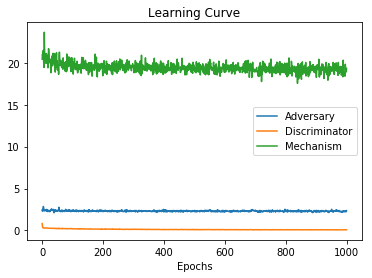

In [8]:
plt.plot(ppan.losses[:,0], label="Adversary")
plt.plot(ppan.losses[:,1], label="Discriminator")
plt.plot(ppan.losses[:,2], label="Mechanism")
plt.legend()
plt.title("Learning Curve")
plt.xlabel("Epochs")
plt.show()

## Testing

In [9]:
test_sample = [1,3,5,7,2,0,13,15,17,19]

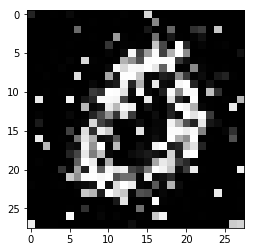

0


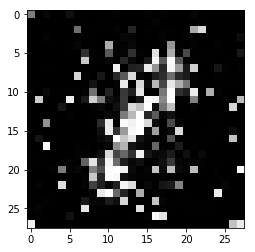

1


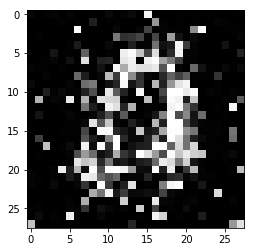

2


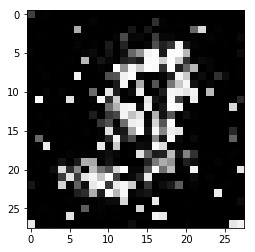

3


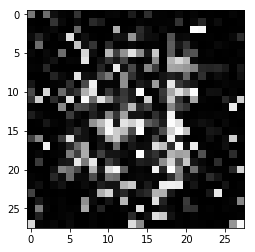

4


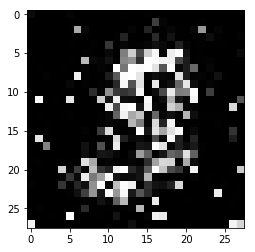

5


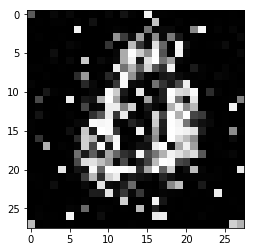

6


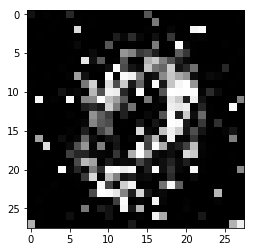

7


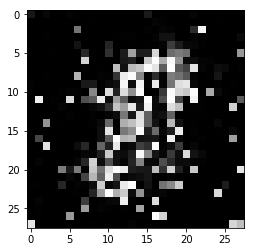

8


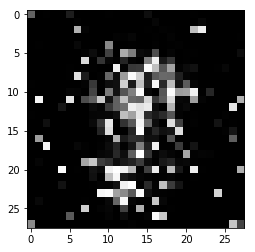

9


In [10]:
for i in test_sample:
    test_img = x_train[i].reshape((1, 784))
    test_noise = np.random.uniform(low=-1, high=1, size=(1, 20))

    test_result = ppan.mechanism.predict(np.hstack((test_img, test_noise))).reshape((28, 28))

    plt.imshow(test_result, cmap="gray")
    plt.show()
    print(y_train[i])